In [50]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
import xarray as xr
import torch
import torch.nn as nn
from scipy import interpolate
from geopack import geopack
import datetime

In [57]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 40 * 140)

    def forward(self, x):
        batch_size = x.size(0)
        # Use the same device as the model for hidden states
        device = next(self.parameters()).device  # Ensure hidden states are on the same device as the model
        
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size, device=device)  # Initial hidden state
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size, device=device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = out.view(-1, 40, 140)
        return out

    def reset_states(self):
        # Reset the internal states of the LSTM layer
        self.lstm.reset_parameters()

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
lookback = 30
def load_model(model_path,lookback=30):

    model = LSTM(lookback, 128, 2)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)

    return model

#NH
NH_sxx_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_sxx_NH_id1.pt") 
NH_fac_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_fac_NH_id1.pt")
NH_syy_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_syy_NH_id1.pt")
NH_pot_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_pot_NH_id2.pt")

In [58]:
path = '/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro_1min_2013-05.csv'
df = pd.read_csv(path)
df['dt'] = pd.to_datetime(df['dt'])
df = df[df['dt'].between('2013-05-14 04:00:00','2013-05-14 08:30:00')]
#resample to two minutes
df=df.set_index('dt').resample('2min').mean().dropna().reset_index()
df

,dt,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle
0,2013-05-14 04:00:00,0.645,3.600,379.5,6.560,0.158055
1,2013-05-14 04:02:00,1.325,3.740,376.0,6.720,0.157784
2,2013-05-14 04:08:00,2.090,3.510,374.0,6.480,0.156990
3,2013-05-14 04:10:00,2.060,3.550,374.0,6.480,0.156880
4,2013-05-14 04:12:00,2.385,3.645,375.0,6.550,0.156617
...,...,...,...,...,...,...
100,2013-05-14 08:22:00,-3.660,-4.700,366.0,9.590,0.223594
101,2013-05-14 08:24:00,-3.865,-4.705,366.0,9.590,0.224477
102,2013-05-14 08:26:00,-4.035,-4.815,368.0,9.625,0.225660
103,2013-05-14 08:28:00,-3.955,-4.625,366.5,9.990,0.226851


In [59]:
lookback = 30

def make_predictions(model, df, hemi, feat, id):

    def split_to_df(df):

        df_2 = df.copy()
        df_2 = df_2.drop(columns=['dt'])

        return df, df_2

    with open(f'/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_scaler_{feat}_{hemi}_id{id}.pkl', 'rb') as f:
        scaler = pickle.load(f)

    df_raw, df_proc= split_to_df(df)
    col_names = df_proc.columns

    norm_arr = scaler.transform(df_proc)
    df_proc = pd.DataFrame(norm_arr, columns=col_names)
    df_proc = df_proc.to_numpy()

    def create_sequences(arr, lookback=lookback):
        X = []
        for i in range(len(arr) - lookback):
            X.append(arr[i:i+lookback].T)

        X = np.array(X)

        return X

    proc_seq = create_sequences(df_proc)
    proc_seq = torch.tensor(proc_seq, dtype=torch.float32).to(device)


    predictions = []
    with torch.no_grad():
        for i in range(len(proc_seq)):
            pred = model(proc_seq[i].unsqueeze(0))
            predictions.append(pred)

    predictions = torch.cat(predictions)
    predictions = predictions.to('cpu').numpy()

    return predictions, df_raw

pot_predictions, NH_raw = make_predictions(NH_pot_model, df, 'NH', 'pot', 2)
fac_predictions, NH_raw = make_predictions(NH_fac_model, df, 'NH', 'fac', 2)
sxx_predictions, NH_raw = make_predictions(NH_sxx_model, df, 'NH', 'sxx', 1)
syy_predictions, NH_raw = make_predictions(NH_syy_model, df, 'NH', 'syy', 1)


/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [61]:
lstm_ds = xr.Dataset({'pot': (['dt', 'mlat', 'mlt'], pot_predictions),
                      'fac': (['dt', 'mlat', 'mlt'], fac_predictions),
                      'sxx': (['dt', 'mlat', 'mlt'], sxx_predictions),
                      'syy': (['dt', 'mlat', 'mlt'], syy_predictions),
                      'BY_GSE': (['dt'], NH_raw['BY_GSE'].values[lookback:]),
                      'BZ_GSE': (['dt'], NH_raw['BZ_GSE'].values[lookback:]),
                      'flow_speed': (['dt'], NH_raw['flow_speed'].values[lookback:]),
                      'proton_density': (['dt'], NH_raw['proton_density'].values[lookback:]),
                      'tilt_angle': (['dt'], NH_raw['tilt_angle'].values[lookback:]),
                 },
                coords = {'dt': NH_raw['dt'].values[lookback:], 'mlat': np.linspace(50, 90, 40), 'mlt': np.linspace(0, 360, 140)/15})

lstm_ds

<xarray.Dataset> Size: 7MB
Dimensions:         (dt: 75, mlat: 40, mlt: 140)
Coordinates:
  * dt              (dt) datetime64[ns] 600B 2013-05-14T05:08:00 ... 2013-05-...
  * mlat            (mlat) float64 320B 50.0 51.03 52.05 ... 87.95 88.97 90.0
  * mlt             (mlt) float64 1kB 0.0 0.1727 0.3453 ... 23.65 23.83 24.0
Data variables:
    pot             (dt, mlat, mlt) float32 2MB 0.7325 0.6922 ... -12.72 -12.76
    fac             (dt, mlat, mlt) float32 2MB 3.848e-06 5.23e-05 ... 0.06407
    sxx             (dt, mlat, mlt) float32 2MB 1.956 1.958 ... 3.827 3.819
    syy             (dt, mlat, mlt) float32 2MB 1.472 1.472 ... 3.787 3.788
    BY_GSE          (dt) float64 600B 1.865 1.94 2.06 ... -4.035 -3.955 -4.03
    BZ_GSE          (dt) float64 600B 2.45 2.635 3.655 ... -4.815 -4.625 -4.68
    flow_speed      (dt) float64 600B 377.0 372.0 373.0 ... 368.0 366.5 371.0
    proton_density  (dt) float64 600B 8.39 8.54 7.93 8.85 ... 9.625 9.99 10.05
    tilt_angle      (dt) float64 600B 0.1558 0.1559 0.1573 ... 0.2269 0.2277

<xarray.Dataset> Size: 7MB
Dimensions:         (dt: 75, mlat: 40, mlt: 140)
Coordinates:
  * dt              (dt) datetime64[ns] 600B 2013-05-14T05:08:00 ... 2013-05-...
  * mlat            (mlat) float64 320B 50.0 51.03 52.05 ... 87.95 88.97 90.0
  * mlt             (mlt) float64 1kB 0.0 0.1727 0.3453 ... 23.65 23.83 24.0
Data variables:
    pot             (dt, mlat, mlt) float32 2MB 0.7325 0.6922 0.6548 ... nan nan
    fac             (dt, mlat, mlt) float32 2MB 3.848e-06 5.23e-05 ... 0.06407
    sxx             (dt, mlat, mlt) float32 2MB 1.956 1.958 ... 3.827 3.819
    syy             (dt, mlat, mlt) float32 2MB 1.472 1.472 ... 3.787 3.788
    BY_GSE          (dt) float64 600B 1.865 1.94 2.06 ... -4.035 -3.955 -4.03
    BZ_GSE          (dt) float64 600B 2.45 2.635 3.655 ... -4.815 -4.625 -4.68
    flow_speed      (dt) float64 600B 377.0 372.0 373.0 ... 368.0 366.5 371.0
    proton_density  (dt) float64 600B 8.39 8.54 7.93 8.85 ... 9.625 9.99 10.05
    tilt_angle      (dt) float64 600B 0.1558 0.1559 0.1573 ... 0.2269 0.2277

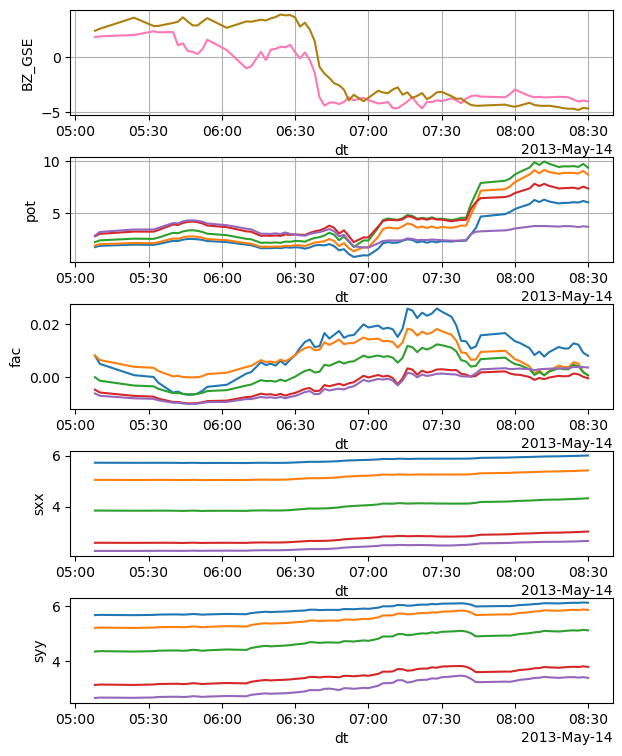

In [64]:
def plot_line(ds):
    ds = ds.copy()
    #keep data between 14 and 22 MLT and nan/mask the rest
    #ds = ds.where((ds['mlt'] >= 14) & (ds['mlt'] <= 23.9), np.nan)
    ds['pot'] = ds['pot'].where(ds['pot'] > 0)

    #slice between 14 and 16 mlt
    fig, ax = plt.subplots(5,1,figsize=(7, 9))

    ds['BY_GSE'].plot(ax=ax[0], label='BY_GSE', color = '#ff77b4')
    ds['BZ_GSE'].plot(ax=ax[0], label='BZ_GSE', color = '#af7f0e')

    ds['pot'].sel(mlt=slice(14, 16)).mean(dim=['mlt','mlat']).plot(ax=ax[1], label='MLT = 14')
    ds['pot'].sel(mlt=slice(16, 18)).mean(dim=['mlt','mlat']).plot(ax=ax[1], label='MLT = 16')
    ds['pot'].sel(mlt=slice(18, 20)).mean(dim=['mlt','mlat']).plot(ax=ax[1], label='MLT = 18')
    ds['pot'].sel(mlt=slice(20, 22)).mean(dim=['mlt','mlat']).plot(ax=ax[1], label='MLT = 20')
    ds['pot'].sel(mlt=slice(22, 24)).mean(dim=['mlt','mlat']).plot(ax=ax[1], label='MLT = 22')
    #ax[1].set_ylim(0, 0.2)

    ds['fac'].sel(mlt=slice(14, 16)).mean(dim=['mlt','mlat']).plot(ax=ax[2], label='MLT = 14')
    ds['fac'].sel(mlt=slice(16, 18)).mean(dim=['mlt','mlat']).plot(ax=ax[2], label='MLT = 16')
    ds['fac'].sel(mlt=slice(18, 20)).mean(dim=['mlt','mlat']).plot(ax=ax[2], label='MLT = 18')
    ds['fac'].sel(mlt=slice(20, 22)).mean(dim=['mlt','mlat']).plot(ax=ax[2], label='MLT = 20')
    ds['fac'].sel(mlt=slice(22, 24)).mean(dim=['mlt','mlat']).plot(ax=ax[2], label='MLT = 22')

    ds['sxx'].sel(mlt=slice(14, 16)).mean(dim=['mlt','mlat']).plot(ax=ax[3], label='MLT = 14')
    ds['sxx'].sel(mlt=slice(16, 18)).mean(dim=['mlt','mlat']).plot(ax=ax[3], label='MLT = 16')
    ds['sxx'].sel(mlt=slice(18, 20)).mean(dim=['mlt','mlat']).plot(ax=ax[3], label='MLT = 18')
    ds['sxx'].sel(mlt=slice(20, 22)).mean(dim=['mlt','mlat']).plot(ax=ax[3], label='MLT = 20')
    ds['sxx'].sel(mlt=slice(22, 24)).mean(dim=['mlt','mlat']).plot(ax=ax[3], label='MLT = 22')

    ds['syy'].sel(mlt=slice(14, 16)).mean(dim=['mlt','mlat']).plot(ax=ax[4], label='MLT = 14')
    ds['syy'].sel(mlt=slice(16, 18)).mean(dim=['mlt','mlat']).plot(ax=ax[4], label='MLT = 16')
    ds['syy'].sel(mlt=slice(18, 20)).mean(dim=['mlt','mlat']).plot(ax=ax[4], label='MLT = 18')
    ds['syy'].sel(mlt=slice(20, 22)).mean(dim=['mlt','mlat']).plot(ax=ax[4], label='MLT = 20')
    ds['syy'].sel(mlt=slice(22, 24)).mean(dim=['mlt','mlat']).plot(ax=ax[4], label='MLT = 22')



    '''
    fig, ax = plt.subplots(1,1,figsize=(5, 5), subplot_kw={'projection': 'polar'})

    theta = np.linspace(0, 360, 140) - 90
    theta_rad = np.deg2rad(theta)
    r = 90 - np.linspace(50, 90, 40)

    pred = ds['prediction'].isel(dt=30).values

    pred = -pred

    ax.pcolormesh(theta_rad, r, pred, cmap='bwr', vmin=-1, vmax=1)
    ax.set_ylim([0, 37])
    ax.set_yticks([0, 10, 20, 30])
    ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    ax.set_xlim([-np.pi, np.pi])
    ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
    ax.grid(True, linestyle='-', linewidth=0.5, zorder=6)'''


    ax[0].grid(True)
    ax[1].grid(True)
    fig.subplots_adjust(hspace=0.4)
    return ds

plot_line(lstm_ds)


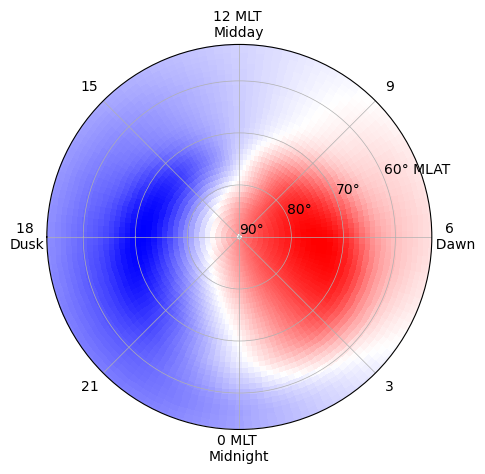

In [73]:
fig, ax = plt.subplots(1,1,figsize=(5, 5), subplot_kw={'projection': 'polar'})

theta = np.linspace(0, 360, 140) - 90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(50, 90, 40)

pred = lstm_ds['pot'].isel(dt=60).values

pred = -pred

ax.pcolormesh(theta_rad, r, pred, cmap='bwr')
ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-', linewidth=0.5, zorder=6)